In [32]:
# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()
##
import splitfolders
##
import torch
from torchvision import transforms, datasets
##
import torchvision.models.quantization as models
from torch import nn
import torch.optim as optim

In [3]:
from pathlib import Path

def count_subs(path:str) -> int:
    dir_ = Path(path)
    
    subs = [f for f in dir_.iterdir() if f.is_dir()]
    return len(subs)

data_dir = "/home/metin/Desktop/workshop/quant.v0/datasets/sea_animals_total/archive"

num_subs = count_subs(data_dir) 
num_subs # Basically number of classes we have for Sea Animals

23

In [10]:
# We had a dataset that didn't splitted
# In this code block we are splitting our dataset into train & val
DATA_DIR = Path('/home/metin/Desktop/workshop/quant.v0/datasets/sea_animals_total/archive')
ROOT_DIR = Path('/home/metin/Desktop/workshop/quant.v0/datasets/sea_animals__splitted')
TRAIN_DIR = ROOT_DIR.joinpath('train')
VAL_DIR = ROOT_DIR.joinpath('val')

splitfolders.ratio(DATA_DIR,
                   output= ROOT_DIR, 
                   seed = 42,
                   ratio = (.8,.2),
                   group_prefix=None,
                   move= False)

In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val' :transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

In [21]:
# Now our dataset root is ROOT_DIR
image_datasets = {x: datasets.ImageFolder(os.path.join(ROOT_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                               shuffle=True, num_workers=8)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

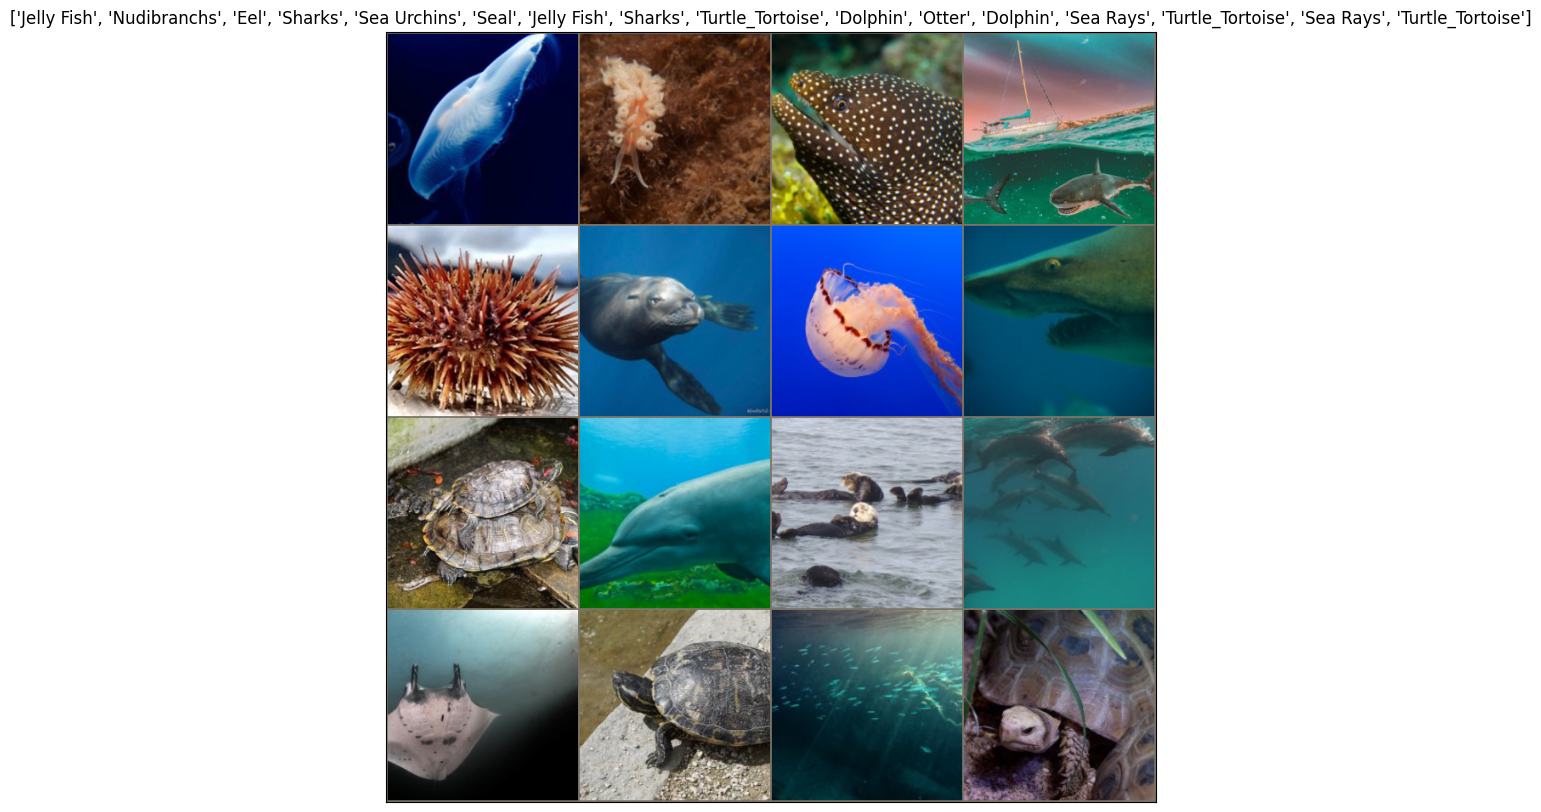

In [23]:
# plotting some images
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model


In [25]:
def visualize_model(model, rows=3, cols=3):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(dataloaders['val']):
      imgs = imgs.cpu()
      lbls = lbls.cpu()

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size()[0]):
        imshow(imgs.data[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [34]:
# You will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

/home/metin/miniconda3/envs/quantization.v0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/metin/miniconda3/envs/quantization.v0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_QuantizedWeights.IMAGENET1K_FBGEMM_V1`. You can also use `weights=ResNet18_QuantizedWeights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
def create_combined_model(model_fe):
    # Isolate the feature extractor
    model_fe_features = nn.Sequential(
        model_fe.quant, # Quantize the input
        model_fe.conv1,
        model_fe.bn1,
        model_fe.relu,
        model_fe.maxpool,
        model_fe.layer1,
        model_fe.layer2,
        model_fe.layer3,
        model_fe.layer4,
        model_fe.avgpool,
        model_fe.dequant, # Dequantize the output
    )
    
    # Create new head
    new_head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 23),
    )
    
    # Combine
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    
    return new_model

In [36]:
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# We are only training the head
optimizer_ft = optim.SGD(new_model.parameters(),
                         lr=0.01, momentum=0.9)

# Decay LR by a factor of *.1 every 8 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Epoch 0/0
----------
train Loss: 2.5778 Acc: 0.5484
val Loss: 1.3805 Acc: 0.7364

Training complete in 5m 44s
Best val Acc: 0.736364


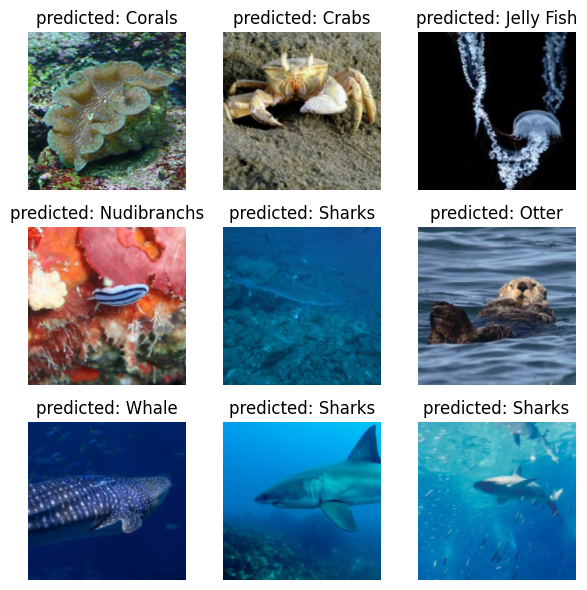

In [38]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=1, device='cpu')

visualize_model(new_model)
plt.tight_layout()

I did computations on my personal laptop. So, .70+ Acc but just for one epoch. Further explorations may can be using ResNet18 on this dataset without doing any Quantization. I prefer stoping here because I just wanted to see how quantization works.

https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#part-1-training-a-custom-classifier-based-on-a-quantized-feature-extractor

https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste/data